The purpose of this notebook is to track true autoregressive processes with non linear measurements and quantised outcomes. 

In [1]:
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('../../../../../')
datapath = './DATA_v0_/'
import numpy as np

import matplotlib
matplotlib.rc('font', size=14)


from qif.qif import qif as qif
from qif.common import generate_AR, noisy_z, projected_msmt, inverse_Ricatti_recursion, J_one_bit, rho, calc_h, scalar_time_inv_sign_quantiser_steady_state, scalar_dre_time_invariant_steady_state
from ls.common import doLSF_forecast

#### Global Plotting and Saving Commands ####

############ Saving Commands #########

ver=0
datapath = '../../../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig = '../svg/paper_v0'
figname = 'QKF'

############ Plotting ########
figx=8
figy=8

In [2]:
def qkf_state_err(x_states, truths):
    '''Returns state estimates from QKF output'''
    
    errs = (x_states - truths)**2
    avg_err_sqr = np.mean(errs, axis=0)
    
    return avg_err_sqr

def scale_AR_process(sequence, thres=0.25*np.pi, reference_pt = 100):
    print("I scaled the AR Process")
    scale = np.max(np.abs(sequence[0:reference_pt]))/thres
    print("with 1/scale factor: ", scale)
    return sequence/scale

def normalise(x):
    norm = np.linalg.norm(x)
    if norm != 0.:
        return x / norm

#### True parameters for AR covariance stationary process

We need to satisfy the following constraints 


For stationarity:
    (a) ph1 + ph2 < 1
    (b) ph1 - ph2 < 1
    (c) phi2| < 1
    
    
For total phase accumulation discerned between -$[\pi/2, \pi/2]$

In [42]:
######## True Autoregressive Process #######
# Stationary ARMA: http://matthieustigler.github.io/Lectures/Lect2ARMA.pdf

# # Case 1: Quantised QKF with No f Bound
ar1 = -0.05# 
ar2 = +0.968
true_wieghts = np.asarray([ar1, ar2]) #0.1*np.ones(5)

# Case 2: Quantised QKF with f Bound
# ar1 = -0.001 # these values are small such that it's likely we stay within phase accumulation bounds
# ar2 = +0.97
# true_wieghts = np.asarray([ar1, ar2]) #0.1*np.ones(5)

#### Noise Parameters

In [43]:
######## True Process Noise Strength
true_oe = 0.001**2
######## True Msmt Noise Strength
true_rk = 0.1**2
####
mean_noise = 0.

#### Set up of Algorithm Parameters (QKF, LSF)

In [47]:
###### Initial State #####
num = 300
order = true_wieghts.shape[0]
#x_init[4] = np.pi


########### LSF ##############
pick_alpha=0.1
n_predict = 20
n_train=num-n_predict
n_start_at=n_train - order + 1

#### Initial Condition , Truth and Data Set Generation with Scaling 

In [48]:
# Set random initial conditions such that we span all possible phase accumulations 
p0init = 100.
x_init = 0.5*np.pi*np.ones(order)
x_init = np.random.uniform(low=-0.5*np.pi, high=np.pi*0.5, size=2)*np.pi*np.ones(order) # random initial condition
# The separation between the first two initial conditions determines how quickly the AR process oscillates and stays 
# or moves out of the phase bounds
x_init = 0.15*np.pi*normalise(x_init) # normalise intial condition to unity and stretch to bounds of \pm pi/2

true_x = generate_AR(x_init, num, true_wieghts, true_oe) + mean_noise
#true_x = scale_AR_process(true_x) # you can't scale an AR process. There won't be any true coefficients.
noisy_z_ = noisy_z(true_x, true_rk)

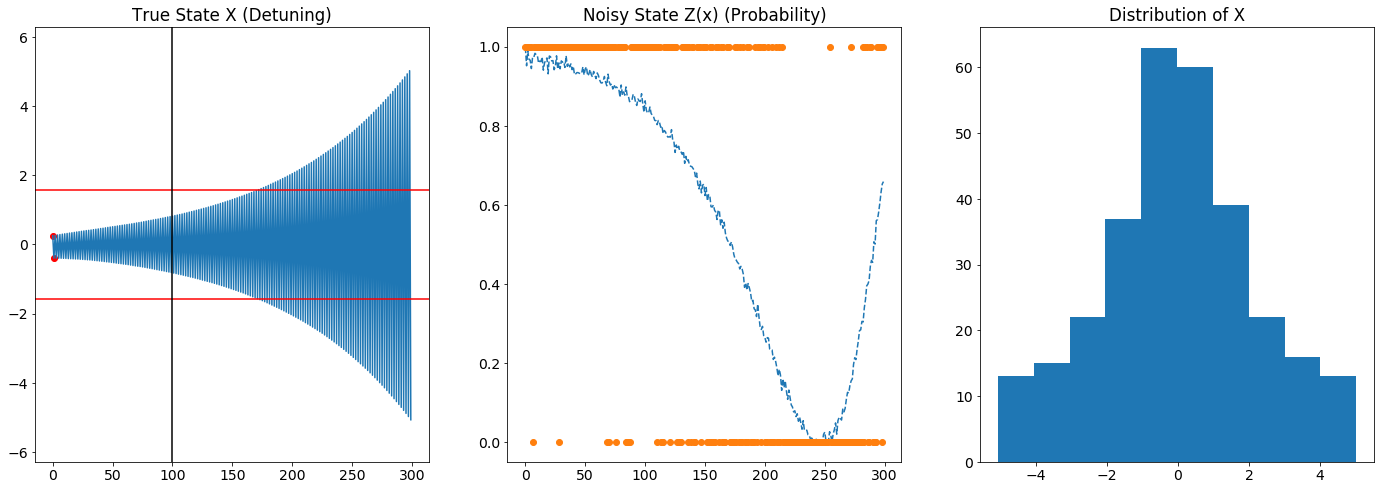

In [50]:
plt.figure(figsize=(figx*3,figy))
plt.subplot(1,3,1)
plt.title('True State X (Detuning)')
plt.plot([0, 1], x_init, 'ro') 
plt.plot(true_x)
plt.axhline(y=0.5*np.pi, c='r')
plt.axhline(y=-0.5*np.pi, c='r')
plt.axvline(x=100, c = 'k')
plt.ylim([-2*np.pi, 2*np.pi])

plt.subplot(1,3,2)
plt.title('Noisy State Z(x) (Probability)')
plt.plot(noisy_z_ + 0.5, '--' )
plt.plot(projected_msmt(noisy_z_ ), 'o')
#plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.title('Distribution of X')
plt.hist(true_x)
plt.show()

####  Run 100 times; with QKF using true dynamics and LSF learned dynamics

In [51]:
# We give the algorithms the true noise strength parameters so that we don't have to worry about filter tuning.

oe = true_oe  
rk = true_rk 
num_of_iterGD = 50
runs = 600

# We store the residuals and the x_hat 
x_true_dynamics = np.zeros((runs, order, num))
x_LSF_dynamics = np.zeros((runs, order, num))

gain_true_dynamics = np.zeros((runs, order, num))
gain_LSF_dynamics = np.zeros((runs, order, num))

truths_ = np.zeros((runs, num))
err_true_dynamics = np.zeros((runs, num))
err_LSF_dynamics = np.zeros((runs, num))

for idx_run in xrange(runs):
    
    # New Truth
    true_x = generate_AR(x_init, num, true_wieghts, true_oe)
    noisy_z_ = noisy_z(true_x, true_rk)
    truths_[idx_run, :] = true_x
    
    # LSF finds the weights
    measurements_train = projected_msmt(noisy_z_)
    measurements_val = projected_msmt(noisy_z_) # true_x doesnt change
    object_ = doLSF_forecast(measurements_train, measurements_val, pick_alpha, 
                       n_start_at, n_predict, order, 
                       steps_between_msmts=1, num_of_iterGD=num_of_iterGD)
    # New Noisy Data
    y_signal = projected_msmt(noisy_z_)
    
    # QIF uses True and LSF Dynamics to make predictions
    predictions, W, x_hat, P_hat, err_true_dynamics[idx_run, :] = qif('truedynamics', y_signal, true_wieghts, true_oe, true_rk, n_train=n_train, n_testbefore=n_predict, 
           n_predict=n_predict, p0=p0init, skip_msmts=1,  save='No')

    predictions_l, W_l, x_hat_l, P_hat_l, err_LSF_dynamics[idx_run, :] = qif('lsfdynamics', y_signal, object_[1][1].ravel() , oe, rk, n_train=n_train, n_testbefore=n_predict, 
               n_predict=n_predict, p0=p0init, skip_msmts=1,  save='No')
    
    x_true_dynamics[idx_run, :, :] = x_hat[:,0,:]
    x_LSF_dynamics[idx_run, :, :] = x_hat_l[:,0,:]
    
    gain_true_dynamics[idx_run, :, :] = W[:,0,:]
    gain_LSF_dynamics[idx_run, :, :] = W_l[:,0,:]

#### Plot Bayes Risk

#### Bayes Risk - with respect to x estimates

In [52]:
predict_zero = np.mean(truths_**2, axis=0)

norm_x_states_ = [qkf_state_err(x_true_dynamics[:, 0, :], truths_)/ predict_zero, 
                  qkf_state_err(x_LSF_dynamics[:, 0, :], truths_) / predict_zero, 
                  predict_zero / predict_zero]

# np.savez('Quantised_QKF_No_f_Bound', QKF_True_Phi=norm_x_states_[0], 
#                                      QKF_LSF_Phi=norm_x_states_[1],
#                                      QKF_PredZero=norm_x_states_[2])

#### Bayes Risk - with respect to z estimates

In [53]:
z_true_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_true_dynamics[:, 0, 0:num]])
z_LSF_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_LSF_dynamics[:, 0, 0:num]])
truths_z = np.asarray([noisy_z(sequence, 0.) for sequence in truths_[:, 0:num]])
predict_one = np.mean((truths_z + 0.5 - 1.)**2, axis=0)

In [54]:
norm_z_states_ = [(qkf_state_err(z_true_dynamics[:, :], truths_z) + 0.5) / predict_one, 
                  (qkf_state_err(z_LSF_dynamics[:, :], truths_z) + 0.5 ) / predict_one,
                  predict_one / predict_one]

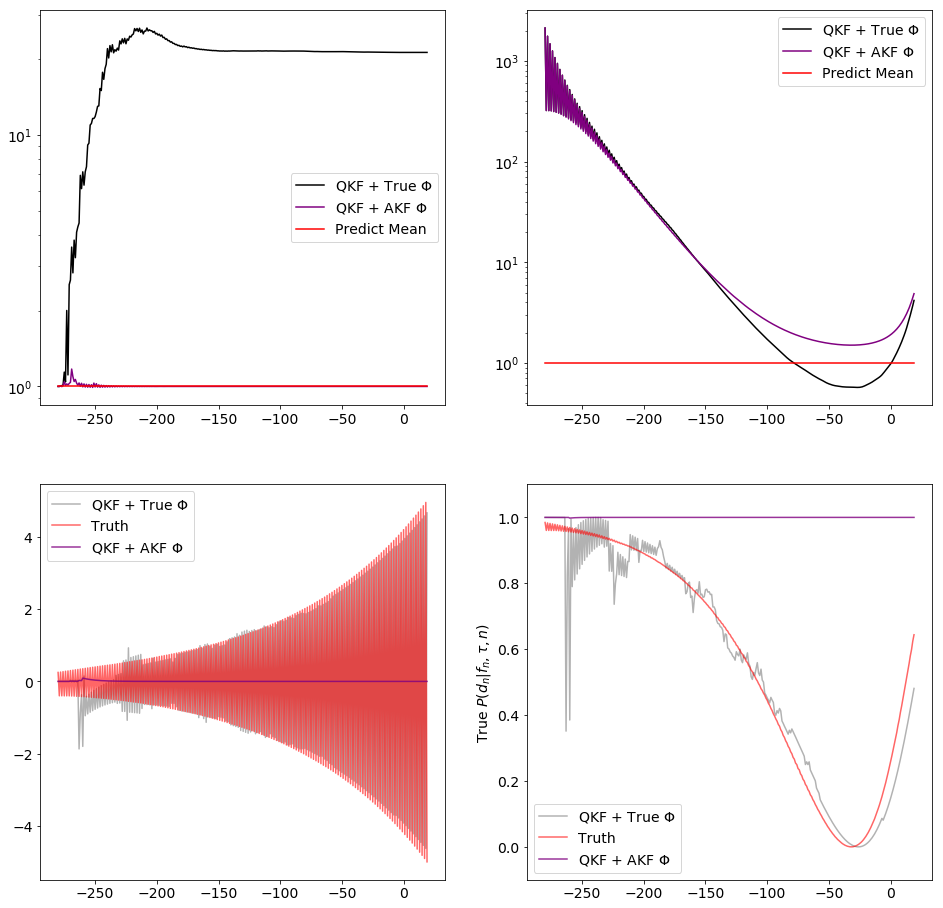

In [55]:
labels = [r'QKF + True $\Phi$', r'QKF + AKF $\Phi$', r'Predict Mean']
color = ['black', 'purple', 'red']

run = int(np.random.uniform(low=0, high = 500))
plt.figure(figsize=(figx*2,figy*2))

plt.subplot(2, 2, 1)
for idx_algo in xrange(len(norm_x_states_)):
    plt.plot(np.arange(-n_train, n_predict, 1), norm_x_states_[idx_algo], label=labels[idx_algo], c=color[idx_algo])
plt.yscale('log')
plt.legend(loc=0)

plt.subplot(2, 2, 3)
plt.plot(np.arange(-n_train, n_predict, 1),x_true_dynamics[run,0,:], label=labels[0], c=color[0],  alpha=0.3)
plt.plot(np.arange(-n_train, n_predict, 1),truths_[run,:], label='Truth', c=color[2], alpha=0.6)
plt.plot(np.arange(-n_train, n_predict, 1),x_LSF_dynamics[run,0,:], label=labels[1], c=color[1],  alpha=0.8)
plt.legend(loc=0)

plt.subplot(2, 2, 2)
for idx_algo in xrange(len(norm_z_states_)):
    plt.plot(np.arange(-n_train, n_predict, 1), norm_z_states_[idx_algo], label=labels[idx_algo], c=color[idx_algo])
plt.yscale('log')
plt.legend(loc=0)

plt.subplot(2, 2, 4)
plt.ylabel(r'True $P(d_n | f_n, \tau, n)$')
plt.plot(np.arange(-n_train, n_predict, 1),z_true_dynamics[run,:] + 0.5, label=labels[0], c=color[0],  alpha=0.3)
plt.plot(np.arange(-n_train, n_predict, 1),truths_z[run,:] + 0.5, label='Truth', c=color[2], alpha=0.6)
plt.plot(np.arange(-n_train, n_predict, 1),z_LSF_dynamics[run,:] + 0.5, label=labels[1], c=color[1],  alpha=0.8)
plt.legend(loc=0)
plt.ylim([-0.1, 1.1])
plt.legend(loc=0)
plt.show()

#### Compare QIF Output 

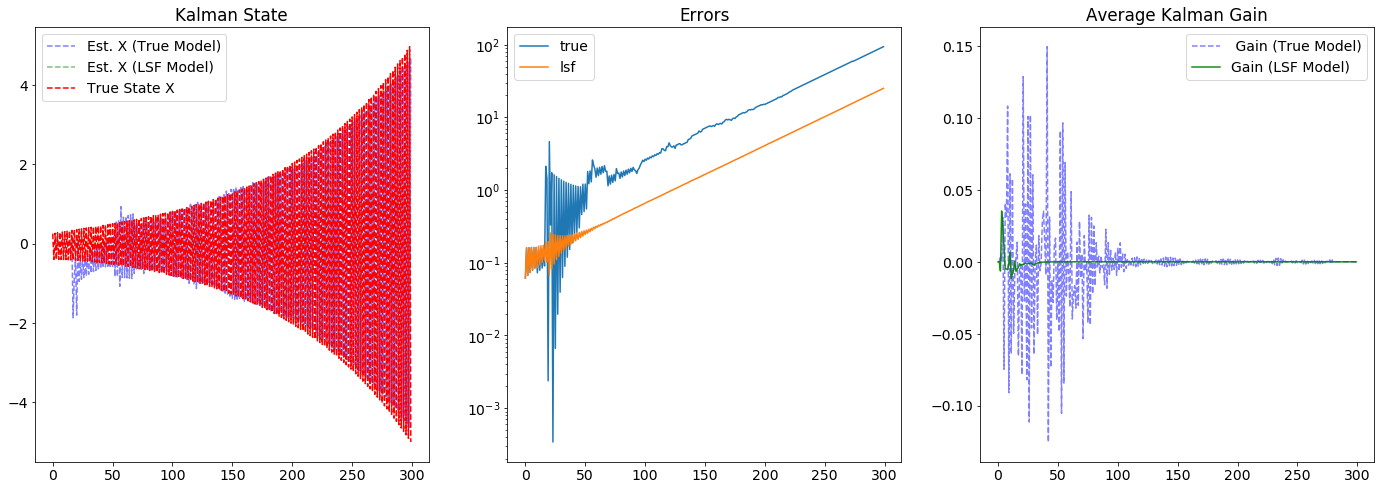

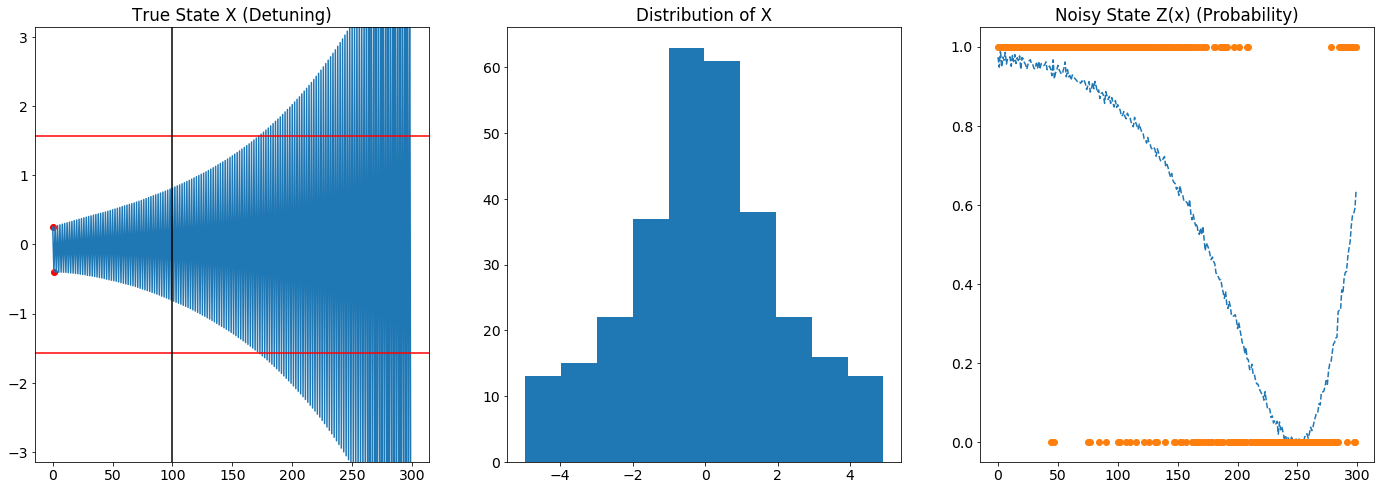

In [56]:
plt.figure(figsize=(figx*3,figy))

plt.subplot(1,3,1)
plt.title('Kalman State')
plt.plot(x_true_dynamics[run,0,:],'b--', alpha=0.5, label= 'Est. X (True Model)')
plt.plot(x_LSF_dynamics[run,0,:],'g--', alpha=0.5, label= 'Est. X (LSF Model)')
plt.plot(truths_[run,:], 'r--',label= 'True State X')
plt.legend(loc=0)

plt.subplot(1,3,2)
plt.title('Errors')
plt.plot((x_true_dynamics[run,0,:]- truths_[run,:])**2, label='true')
plt.plot((x_LSF_dynamics[run,0,:]- truths_[run,:])**2, label='lsf')
plt.yscale('log')
plt.legend(loc=0)

plt.subplot(1,3,3)
plt.title('Average Kalman Gain')
plt.plot(np.mean(gain_true_dynamics[:,0,:], axis=0),'b--', alpha=0.5, label= ' Gain (True Model)')
plt.plot(np.mean(gain_LSF_dynamics[:,0,:], axis=0),'g', alpha=0.9, label= 'Gain (LSF Model)')
plt.legend(loc=0)
plt.show()


plt.figure(figsize=(figx*3,figy))
plt.subplot(1,3,1)
plt.title('True State X (Detuning)')
plt.plot([0, 1], x_init, 'ro') 
plt.plot(truths_[run,:])
plt.axhline(y=0.5*np.pi, c='r')
plt.axhline(y=-0.5*np.pi, c='r')
plt.axvline(x=100, c = 'k')
plt.ylim([-np.pi, np.pi])

plt.subplot(1,3,3)
plt.title('Noisy State Z(x) (Probability)')
plt.plot(noisy_z_ + 0.5, '--' )
plt.plot(projected_msmt(noisy_z_ ), 'o')
#plt.ylim([-0.1, 1.1])

plt.subplot(1,3,2)
plt.title('Distribution of X')
plt.hist(true_x)
plt.show()

#### Check Weights from LSF vs. Truth

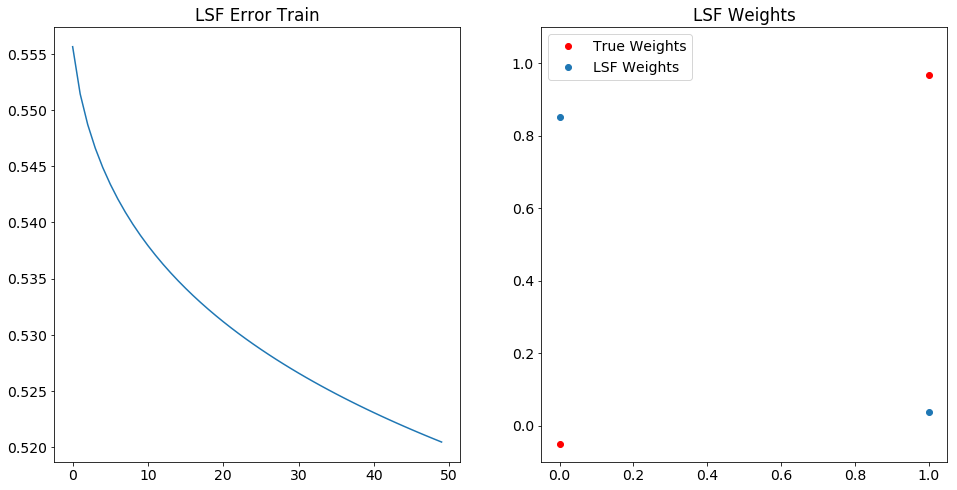

In [57]:
plt.figure(figsize=(figx*2,figy))
plt.subplot(1,2,1)
plt.title('LSF Error Train')
plt.plot(object_[4][1])
plt.subplot(1,2,2)
plt.title('LSF Weights')
plt.plot(range(true_wieghts.shape[0]), true_wieghts, 'ro', label='True Weights')
plt.plot(range(order), object_[1][1], 'o', label= 'LSF Weights')
plt.ylim([-0.1, 1.1])
plt.legend(loc=0)
plt.show()